# 1. Import Libraries and Datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import confusion_matrix

# Import Datasets
# 這個Dataset由Preprocessing notebook得到
df = pd.read_csv('../data/processed/data_processed.csv')

# 2. Create Function

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate the accuracy, precision, recall, and F1 score
def get_test_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')

# 3. Modeling (Classification)

In [37]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
y = df['FraudFound_P']

# 將train, validation, test data 切成 80%, 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

這邊先在沒有篩選特徵、沒有使用抽樣方法的資料做一個基礎模型，以便跟後面的模型做比較。

In [38]:
# Create a baseline model without any processing first
# Create XGBoost classifier
import xgboost as xgb
xgb_base = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')

# Train the model
xgb_base.fit(X_train, y_train)

# Make predictions
y_pred = xgb_base.predict(X_test)
y_prob = xgb_base.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)


Accuracy: 0.9413
Precision: 0.7500
Recall: 0.0324
F1 Score: 0.0622
AUC: 0.8492


## 3.1 Use RFECV to select features (with XGBoost + 欠採樣)

在這之前，我測試了各種抽樣方法與分類模型的搭配，得到最好的模型是使用隨機欠採樣的XGBoost (Recall, Precision皆表現較好)。
所以我接著會使用這個模型(XGBoost + 欠採樣)進行後面的優化。  

特徵篩選的部分，我使用了RFECV (特徵遞迴消除交叉驗證)。RFECV 通過遞迴消除的方式逐步減少不重要的特徵，並使用交叉驗證來評估每個特徵子集的模型表現，以選出對模型效果最好的特徵組合。這不僅可以降低模型的複雜度，也可以避免模型受到太多噪音干擾。

In [39]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Optimal number of features: 21

Selected features:
AgeOfPolicyHolder_41 to 50
Fault
PoliceReportFiled
PolicyType_Sedan - Collision
PolicyType_Sedan - Liability
HiskRisk_DeductibleAMT
Month_Dec
Month_Mar
WeekOfMonth_2
WeekOfMonth_3
WeekOfMonth_4
DayOfWeek_Sunday
Year_1995
Year_1996
MonthClaimed_Aug
MonthClaimed_Dec
MonthClaimed_Feb
MonthClaimed_Jan
MonthClaimed_Jun
MonthClaimed_Nov
WeekOfMonthClaimed_2


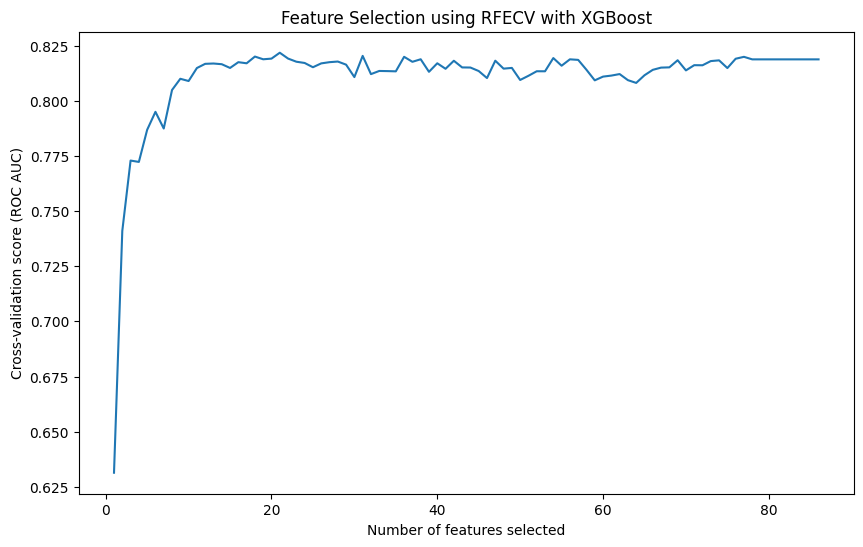

In [40]:
# Use RFECV with XGBoost for feature selection
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')

# Initialize RFECV
rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=5,
    scoring='roc_auc',
    min_features_to_select=1,
    n_jobs=1
)

# Fit RFECV
rfecv.fit(X_train_rus, y_train_rus)

# Get selected features
selected_features = X_train_rus.columns[rfecv.support_]

print(f"Optimal number of features: {rfecv.n_features_}")
print("\nSelected features:")
for feature in selected_features:
    print(feature)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score (ROC AUC)')
plt.title('Feature Selection using RFECV with XGBoost')
plt.show()



由上面的RFECV圖可以看到，特徵在20個左右的表現已達穩定，再增加特徵數量後的表現沒有顯著提升。這代表前20個左右的特徵已經包含大部分有用的訊息，後續的特徵貢獻有限。刪除多餘特徵可以簡化模型，也避免過擬合。

In [41]:
X_train_rus_selected = X_train_rus[selected_features]
X_test_selected = X_test[selected_features]
X_train_rus_selected.shape

(1476, 21)

In [42]:
# Train XGBoost model on selected features 
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb.fit(X_train_rus_selected, y_train_rus)

# Make predictions on test set
y_pred = xgb.predict(X_test_selected)
y_prob = xgb.predict_proba(X_test_selected)[:, 1]

# Get performance metrics
get_test_metrics(y_test, y_pred, y_prob)

Accuracy: 0.7004
Precision: 0.1543
Recall: 0.8919
F1 Score: 0.2632
AUC: 0.8527


這邊可以看到模型的性能得到了顯著的提升，而且我們將特徵數量從86個降到了21個。  
下面我們透過SHAP來了解模型是如何做預測的。

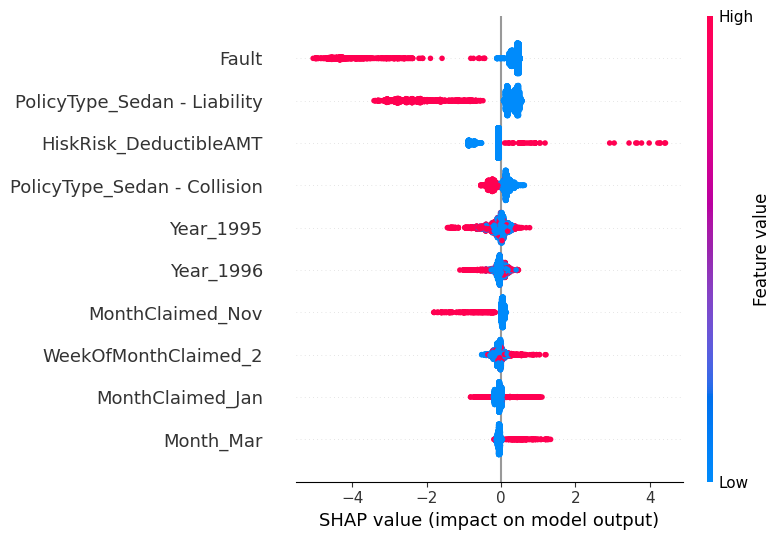

In [43]:
# Calculate SHAP values
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_selected)

# Create detailed SHAP summary plot showing feature impacts for top 10 features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_selected, max_display=10)


## 3.2 Balanced Ensemble Models 

雖然目前XGBoost+欠採樣表現不差，但是這個模型並沒有充分運用訓練集的資料。由於使用欠採樣的關係，我們只使用了738個非詐欺樣本（因為詐欺樣本只有738個），等於我們浪費了大概93%的訓練資料。  

為了能更佳利用所有訓練資料，這邊使用了Balanced Ensemble的方法。想法就是訓練很多個XGBoost子模型，在每一個Ensemble model的子模型中皆採用欠採樣 + XGBoost，而每一個子模型使用的是同一組詐欺樣本搭配不同組的非詐欺樣本(使用Bootstrap)。透過這種方法，最後再將子模型結合起來，我們就可以更充分地運用訓練集了。

In [44]:
# 這邊一樣使用RFECV篩選出的重要特徵
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [49]:
# Train a Balanced Bagging Classifier (base model: XGBoost)
import xgboost as xgb
from imblearn.ensemble import BalancedBaggingClassifier

xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')
balbag = BalancedBaggingClassifier(estimator = xgb, n_estimators=500, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = 1, random_state = 42)

balbag.fit(X_train_selected, y_train)
y_pred = balbag.predict(X_test_selected)
y_prob = balbag.predict_proba(X_test_selected)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)

Accuracy: 0.6962
Precision: 0.1557
Recall: 0.9189
F1 Score: 0.2662
AUC: 0.8559


這個最終模型在AUC, Precision, F1皆有提升，Recall更是快達到了0.92。代表這個Balanced Ensemble的方法能夠幫助我們更充分地運用資料。  

由於 Balanced Ensemble還有其他方法，下面我也做了一個 Balanced Random Forest (子模型是較簡單的決策樹)與 EasyEnsembleClassifier (子模型是AdaBoost)，但各項metric都還是 Balanced Bagging (XGBoost+欠採樣)表現較佳，所以後面也只會對這個模型做Hyperparameter Tuning。

In [17]:
# Train a Balanced Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, 
                                    random_state=42,
                                    sampling_strategy='majority',
                                    replacement=True,
                                    n_jobs=1)

brf.fit(X_train_selected, y_train)
y_pred = brf.predict(X_test_selected)
y_prob = brf.predict_proba(X_test_selected)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)


/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Accuracy: 0.7004
Precision: 0.1550
Recall: 0.8973
F1 Score: 0.2643
AUC: 0.8446


In [30]:
# Train an EasyEnsemble classifier
from imblearn.ensemble import EasyEnsembleClassifier

ee = EasyEnsembleClassifier(n_estimators=100, random_state=42)
ee.fit(X_train_selected, y_train)
y_pred = ee.predict(X_test_selected)
y_prob = ee.predict_proba(X_test_selected)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)


Accuracy: 0.5911
Precision: 0.1232
Recall: 0.9514
F1 Score: 0.2182
AUC: 0.8060


下面對表現最好的模型(Balanced Bagging)做超參數調整及特徵重要性的分析。

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

base_xgb = XGBClassifier(eval_metric='logloss', random_state=42)
balbag = BalancedBaggingClassifier(
    estimator=base_xgb,
    random_state=42
)

param_distributions = {
    # BalancedBagging 參數
    'n_estimators': randint(100, 1000),
    'sampling_strategy': ['majority', 'not minority', 'all'],
    'replacement': [True, False],
    
    # XGBoost 參數
    'estimator__learning_rate': uniform(0.01, 0.29),  # 0.01 到 0.3
    'estimator__max_depth': randint(3, 11),           # 3 到 10
    'estimator__min_child_weight': randint(1, 6),     # 1 到 5
    'estimator__subsample': uniform(0.6, 0.4),        # 0.6 到 1.0
    'estimator__colsample_bytree': uniform(0.6, 0.4), # 0.6 到 1.0
    'estimator__gamma': uniform(0, 0.5),              # 0 到 0.5
}

# 創建 RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=balbag,
    param_distributions=param_distributions,
    n_iter=50,               # 嘗試50種參數組合
    scoring='roc_auc',           # 使用 F1 分數作為評估指標
    cv=5,                   # 5折交叉驗證
    n_jobs=-1,             
    verbose=2,              
    random_state=42,
    return_train_score=True 
)

# 執行隨機搜索
random_search.fit(X_train_selected, y_train)

# 印出最佳結果
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {random_search.best_score_:.4f}")

# 使用最佳模型進行預測
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_selected)
y_prob = best_model.predict_proba(X_test_selected)[:, 1]

# 評估最佳模型
print("\nTest Set Performance:")
get_test_metrics(y_test, y_pred, y_prob)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END estimator__colsample_bytree=0.7836995567863468, estimator__gamma=0.16685430556951092, estimator__learning_rate=0.05143137719736283, estimator__max_depth=5, estimator__min_child_weight=5, estimator__subsample=0.9879639408647978, n_estimators=591, replacement=False, sampling_strategy=not minority; total time=  16.0s
[CV] END estimator__colsample_bytree=0.7836995567863468, estimator__gamma=0.16685430556951092, estimator__learning_rate=0.05143137719736283, estimator__max_depth=5, estimator__min_child_weight=5, estimator__subsample=0.9879639408647978, n_estimators=591, replacement=False, sampling_strategy=not minority; total time=  15.9s
[CV] END estimator__colsample_bytree=0.7836995567863468, estimator__gamma=0.16685430556951092, estimator__learning_rate=0.05143137719736283, estimator__max_depth=5, estimator__min_child_weight=5, estimator__subsample=0.9879639408647978, n_estimators=591, replacement=False, sampling_strat

In [18]:
# Calculate permutation importance
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go

# Perform permutation importance calculation
result = permutation_importance(balbag, X_test_selected, y_test, 
                              n_repeats=10, 
                              random_state=42,
                              n_jobs=1)

# Create dataframe of feature importances
importances = pd.DataFrame(
    {'feature': selected_features,
     'importance_mean': result.importances_mean}
)

# Sort features by mean importance and get top 10
importances = importances.sort_values('importance_mean', ascending=True).tail(10)

# Create plotly horizontal bar chart
fig = go.Figure(go.Bar(
    x=importances['importance_mean'],
    y=importances['feature'],
    orientation='h'
))

fig.update_layout(
    title='Feature Importance (Permutation) - Top 10 Features',
    xaxis_title='Permutation Importance',
    yaxis_title='Features',
    height=600,
    width=800
)

fig.show()

## 3.3 Error Analysis

最終模型的Recall為0.92, Precision為0.16，以下將了解那些模型預測錯誤的樣本，分析被預測為詐欺的正常樣本(False Positive)與沒有被找出來的詐欺樣本(False NEgative)。

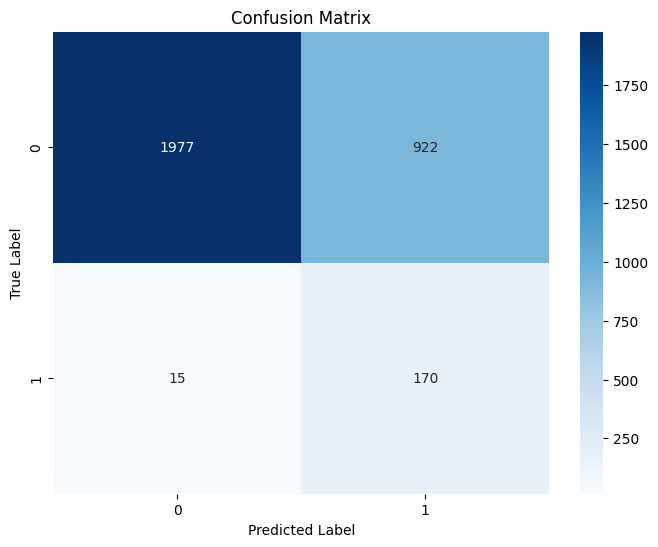

In [79]:
# Get predictions
y_pred = balbag.predict(X_test_selected)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [80]:
false_positives = X_test_selected[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test_selected[(y_test == 1) & (y_pred == 0)]

In [89]:
def analyze_feature_false_negatives(X_test_selected, y_test, y_pred):
    # 遍歷每個特徵
    for feature in X_test_selected.columns:
        # 使用布林遮罩來選擇特徵為 True 的案件
        feature_mask = X_test_selected[feature] == True
        
        # 使用相同的遮罩取得實際值和預測值
        y_true_feature = y_test[feature_mask]
        y_pred_feature = y_pred[feature_mask]
        
        # 計算其實是詐欺，但被模型預測為正常的樣本
        false_negatives = ((y_true_feature == 1) & (y_pred_feature == 0)).sum()
        total_fraud = (y_true_feature == 1).sum()
        
        # 只有在有詐欺案件時才印出分析結果
        if total_fraud > 0:
            print(f"\n{feature}特徵為True的案件詐欺分析:")
            print(f"詐欺案件總數: {total_fraud}")
            print(f"未被偵測出的詐欺案件數: {false_negatives}")
            print(f"漏報率: {false_negatives/total_fraud:.2%}")

# 執行分析
analyze_feature_false_negatives(X_test_selected, y_test, y_pred)



AgeOfPolicyHolder_41 to 50特徵為True的案件詐欺分析:
詐欺案件總數: 34
未被偵測出的詐欺案件數: 4
漏報率: 11.76%

Fault特徵為True的案件詐欺分析:
詐欺案件總數: 5
未被偵測出的詐欺案件數: 0
漏報率: 0.00%

PoliceReportFiled特徵為True的案件詐欺分析:
詐欺案件總數: 4
未被偵測出的詐欺案件數: 3
漏報率: 75.00%

PolicyType_Sedan - Collision特徵為True的案件詐欺分析:
詐欺案件總數: 74
未被偵測出的詐欺案件數: 6
漏報率: 8.11%

PolicyType_Sedan - Liability特徵為True的案件詐欺分析:
詐欺案件總數: 5
未被偵測出的詐欺案件數: 5
漏報率: 100.00%

HiskRisk_DeductibleAMT特徵為True的案件詐欺分析:
詐欺案件總數: 7
未被偵測出的詐欺案件數: 0
漏報率: 0.00%

Month_Dec特徵為True的案件詐欺分析:
詐欺案件總數: 16
未被偵測出的詐欺案件數: 2
漏報率: 12.50%

Month_Mar特徵為True的案件詐欺分析:
詐欺案件總數: 19
未被偵測出的詐欺案件數: 0
漏報率: 0.00%

WeekOfMonth_2特徵為True的案件詐欺分析:
詐欺案件總數: 36
未被偵測出的詐欺案件數: 6
漏報率: 16.67%

WeekOfMonth_3特徵為True的案件詐欺分析:
詐欺案件總數: 38
未被偵測出的詐欺案件數: 2
漏報率: 5.26%

WeekOfMonth_4特徵為True的案件詐欺分析:
詐欺案件總數: 41
未被偵測出的詐欺案件數: 2
漏報率: 4.88%

DayOfWeek_Sunday特徵為True的案件詐欺分析:
詐欺案件總數: 27
未被偵測出的詐欺案件數: 2
漏報率: 7.41%

Year_1995特徵為True的案件詐欺分析:
詐欺案件總數: 60
未被偵測出的詐欺案件數: 2
漏報率: 3.33%

Year_1996特徵為True的案件詐欺分析:
詐欺案件總數: 44
未被偵測出的詐欺案件數: 6
漏報率: 13.64%

MonthClaimed_Aug特徵為True

In [88]:
def analyze_feature_false_positives(X_test_selected, y_test, y_pred):
    # 遍歷每個特徵
    for feature in X_test_selected.columns:
        # 使用布林遮罩來選擇特徵為 True 的案件
        feature_mask = X_test_selected[feature] == True
        
        # 使用相同的遮罩取得實際值和預測值
        y_true_feature = y_test[feature_mask]
        y_pred_feature = y_pred[feature_mask]
        
        # 計算其實不是詐欺，但被模型預測為詐欺的樣本
        false_positives = ((y_true_feature == 0) & (y_pred_feature == 1)).sum()
        total_normal = (y_true_feature == 0).sum()
        
        # 只有在有正常案件時才印出分析結果
        if total_normal > 0:
            print(f"\n{feature}特徵為True的案件誤報分析:")
            print(f"正常案件總數: {total_normal}")
            print(f"誤判為詐欺的案件數: {false_positives}")
            print(f"誤報率: {false_positives/total_normal:.2%}")

# 執行分析
analyze_feature_false_positives(X_test_selected, y_test, y_pred)



AgeOfPolicyHolder_41 to 50特徵為True的案件誤報分析:
正常案件總數: 547
誤判為詐欺的案件數: 159
誤報率: 29.07%

Fault特徵為True的案件誤報分析:
正常案件總數: 823
誤判為詐欺的案件數: 4
誤報率: 0.49%

PoliceReportFiled特徵為True的案件誤報分析:
正常案件總數: 92
誤判為詐欺的案件數: 13
誤報率: 14.13%

PolicyType_Sedan - Collision特徵為True的案件誤報分析:
正常案件總數: 1019
誤判為詐欺的案件數: 539
誤報率: 52.89%

PolicyType_Sedan - Liability特徵為True的案件誤報分析:
正常案件總數: 983
誤判為詐欺的案件數: 0
誤報率: 0.00%

HiskRisk_DeductibleAMT特徵為True的案件誤報分析:
正常案件總數: 45
誤判為詐欺的案件數: 24
誤報率: 53.33%

Month_Dec特徵為True的案件誤報分析:
正常案件總數: 221
誤判為詐欺的案件數: 34
誤報率: 15.38%

Month_Mar特徵為True的案件誤報分析:
正常案件總數: 256
誤判為詐欺的案件數: 78
誤報率: 30.47%

WeekOfMonth_2特徵為True的案件誤報分析:
正常案件總數: 672
誤判為詐欺的案件數: 229
誤報率: 34.08%

WeekOfMonth_3特徵為True的案件誤報分析:
正常案件總數: 667
誤判為詐欺的案件數: 225
誤報率: 33.73%

WeekOfMonth_4特徵為True的案件誤報分析:
正常案件總數: 614
誤判為詐欺的案件數: 179
誤報率: 29.15%

DayOfWeek_Sunday特徵為True的案件誤報分析:
正常案件總數: 345
誤判為詐欺的案件數: 136
誤報率: 39.42%

Year_1995特徵為True的案件誤報分析:
正常案件總數: 983
誤判為詐欺的案件數: 330
誤報率: 33.57%

Year_1996特徵為True的案件誤報分析:
正常案件總數: 804
誤判為詐欺的案件數: 191
誤報率: 23.76%

MonthClai

# 4. Modeling (Anomaly Detection)

由於詐欺偵測中的詐欺案件本身可以當作異常，所以我也想用異常偵測模型來處理。以下會是使用三個模型：Isolation Forest, One-Class SVM, AutoEncoder。

In [446]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
y = df['FraudFound_P']

# 將train, validation, test data 切成 70%, 15%, 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [447]:
# 先結合X_train與y_train，因為異常偵測算法只使用正常資料訓練
df_train = pd.concat([X_train, pd.DataFrame(y_train, columns=['FraudFound_P'])], axis = 1)

# 將訓練集分成正常樣本（多數類別）和異常樣本（少數類別）
df_train_normal = df_train[df_train['FraudFound_P'] == 0]
df_train_anomaly = df_train[df_train['FraudFound_P'] == 1]

# 分離特徵跟目標變數（非監督學習訓練時只用到正常樣本的特徵)
X_train_normal = df_train_normal.drop(columns = 'FraudFound_P')

In [448]:
# Isolation Forest、One-Class SVM與Autoencoder都會受距離影響，要標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

## 4.1 Isolation Forest

In [449]:
from sklearn.ensemble import IsolationForest

# 詐欺樣本比例為6%，contimination設為0.06
iso_forest = IsolationForest(contamination=0.06, random_state=42)  

# 訓練模型（僅使用正常樣本）
iso_forest.fit(X_train_normal_scaled)

IsolationForest(contamination=0.06, random_state=42)

In [453]:
# 在驗證集上預測異常分數
y_valid_scores = iso_forest.decision_function(X_valid_scaled)

# 計算不同閾值下的precision、recall和F1分數
thresholds = np.linspace(y_valid_scores.min(), y_valid_scores.max(), 50)
results = []

for threshold in thresholds:
    # 將異常分數轉換為預測標籤 (小於閾值為異常=1，大於閾值為正常=0)
    y_pred = (y_valid_scores < threshold).astype(int)
    
    # 計算各項指標
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# 轉換為DataFrame並找到最佳閾值
results_df = pd.DataFrame(results)
best_f1_idx = results_df['f1'].idxmax()
best_threshold = results_df.loc[best_f1_idx, 'threshold']

print("Results for different thresholds:")
print("\nThreshold  Precision  Recall  F1")
print("-" * 40)
for _, row in results_df.iterrows():
    print(f"{row['threshold']:9.3f}  {row['precision']:9.3f}  {row['recall']:6.3f}  {row['f1']:6.3f}")

print("\nBest Results:")
print("-" * 40)
print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {results_df.loc[best_f1_idx, 'f1']:.3f}")
print(f"Precision at best threshold: {results_df.loc[best_f1_idx, 'precision']:.3f}")
print(f"Recall at best threshold: {results_df.loc[best_f1_idx, 'recall']:.3f}")


Results for different thresholds:

Threshold  Precision  Recall  F1
----------------------------------------
   -0.060      0.000   0.000   0.000
   -0.057      0.000   0.000   0.000
   -0.053      0.000   0.000   0.000
   -0.050      0.000   0.000   0.000
   -0.046      0.200   0.007   0.014
   -0.043      0.125   0.007   0.014
   -0.039      0.111   0.007   0.014
   -0.036      0.100   0.007   0.013
   -0.032      0.083   0.007   0.013
   -0.029      0.053   0.007   0.013
   -0.025      0.043   0.007   0.012
   -0.022      0.059   0.014   0.023
   -0.018      0.060   0.022   0.032
   -0.015      0.086   0.043   0.057
   -0.011      0.079   0.050   0.061
   -0.008      0.075   0.058   0.065
   -0.004      0.069   0.065   0.067
   -0.000      0.057   0.065   0.060
    0.003      0.066   0.094   0.078
    0.007      0.072   0.122   0.090
    0.010      0.071   0.151   0.097
    0.014      0.086   0.230   0.125
    0.017      0.078   0.252   0.119
    0.021      0.077   0.288   0.121
   

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



透過validation set在F1上的表現找出最佳閾值(0.028)，並在測試集上做測試

In [456]:
# 使用最佳閾值在測試集上進行預測
y_test_scores = iso_forest.decision_function(X_test_scaled)
y_test_pred = (y_test_scores < best_threshold).astype(int)

# 計算測試集上的指標
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Isolation Forest performance:")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1 Score: {test_f1:.3f}")


Isolation Forest performance:
Precision: 0.063
Recall: 0.312
F1 Score: 0.104


## 4.2 One-Class SVM

In [457]:
from sklearn.svm import OneClassSVM

OSVM = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.1)
OSVM.fit(X_train_normal_scaled)

OneClassSVM(gamma=0.1, nu=0.1)

In [459]:
# 在驗證集上預測異常分數
y_valid_scores = OSVM.decision_function(X_valid_scaled)

# 計算不同閾值下的precision、recall和F1分數
thresholds = np.linspace(y_valid_scores.min(), y_valid_scores.max(), 50)
results = []

for threshold in thresholds:
    # 將異常分數轉換為預測標籤 (小於閾值為異常=1，大於閾值為正常=0)
    y_pred = (y_valid_scores < threshold).astype(int)
    
    # 計算各項指標
    precision = precision_score(y_valid, y_pred, zero_division=0)
    recall = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# 轉換為DataFrame並找到最佳閾值
results_df = pd.DataFrame(results)
best_f1_idx = results_df['f1'].idxmax()
best_threshold = results_df.loc[best_f1_idx, 'threshold']

print("Results for different thresholds:")
print("\nThreshold  Precision  Recall  F1")
print("-" * 40)
for _, row in results_df.iterrows():
    print(f"{row['threshold']:9.3f}  {row['precision']:9.3f}  {row['recall']:6.3f}  {row['f1']:6.3f}")

print("\nBest Results:")
print("-" * 40)
print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {results_df.loc[best_f1_idx, 'f1']:.3f}")
print(f"Precision at best threshold: {results_df.loc[best_f1_idx, 'precision']:.3f}")
print(f"Recall at best threshold: {results_df.loc[best_f1_idx, 'recall']:.3f}")

Results for different thresholds:

Threshold  Precision  Recall  F1
----------------------------------------
   -0.135      0.000   0.000   0.000
   -0.130      0.070   0.245   0.109
   -0.125      0.076   0.360   0.125
   -0.121      0.079   0.453   0.134
   -0.116      0.072   0.489   0.125
   -0.112      0.072   0.554   0.127
   -0.107      0.071   0.612   0.128
   -0.103      0.073   0.683   0.132
   -0.098      0.072   0.734   0.131
   -0.094      0.070   0.763   0.128
   -0.089      0.070   0.813   0.129
   -0.085      0.069   0.842   0.127
   -0.080      0.067   0.856   0.124
   -0.076      0.064   0.856   0.120
   -0.071      0.062   0.856   0.116
   -0.067      0.062   0.885   0.117
   -0.062      0.062   0.906   0.116
   -0.058      0.061   0.921   0.115
   -0.053      0.060   0.921   0.113
   -0.049      0.060   0.935   0.113
   -0.044      0.060   0.950   0.113
   -0.040      0.061   0.964   0.114
   -0.035      0.061   0.971   0.114
   -0.031      0.060   0.971   0.113
   

In [460]:
# 使用最佳閾值在測試集上進行預測
y_test_scores = OSVM.decision_function(X_test_scaled)
y_test_pred = (y_test_scores < best_threshold).astype(int)

# 計算測試集上的指標
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

print("One-Class SVM performance:")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}") 
print(f"F1 Score: {test_f1:.3f}")


One-Class SVM performance:
Precision: 0.073
Recall: 0.377
F1 Score: 0.122


## 4.3 AutoEncoder

In [462]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# Build autoencoder model
input_dim = X_train_normal_scaled.shape[1]

autoencoder = Sequential([
    # Encoder
    Input(shape=(input_dim,)), 
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    
    # Decoder
    Dense(16, activation='relu'), 
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')


In [463]:
# Train the model
history = autoencoder.fit(
    X_train_normal_scaled, 
    X_train_normal_scaled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_valid_scaled, X_valid_scaled),
    verbose=1
)

# Get reconstruction error
train_pred = autoencoder.predict(X_train_normal_scaled)
valid_pred = autoencoder.predict(X_valid_scaled)

train_mse = np.mean(np.power(X_train_normal_scaled - train_pred, 2), axis=1)
valid_mse = np.mean(np.power(X_valid_scaled - valid_pred, 2), axis=1)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1154 - val_loss: 0.9972
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.9527 - val_loss: 0.9468
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.9056 - val_loss: 0.9160
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.8917 - val_loss: 0.9012
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.8679 - val_loss: 0.8920
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 0.8653 - val_loss: 0.8864
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 0.8576 - val_loss: 0.8825
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.8445 - val_loss: 0.8781
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.8865 - val_loss: 0.8751
Epoch 10/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.8907 - val_loss: 0.8721
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.8625 - val_loss: 0.8695
Epoch 12/50
318/318 ━━━━━━━━━━━━

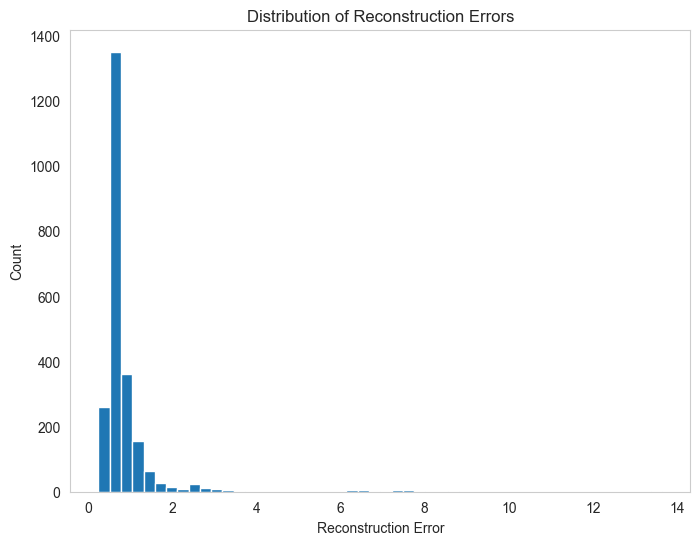

In [464]:
# Plot reconstruction error distribution
plt.figure(figsize=(8, 6))
plt.hist(valid_mse, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.show()

In [465]:
# 設定閾值範圍
thresholds = np.linspace(0.1, 10, 50)

best_threshold = 0.1  # 初始閾值
best_f1 = 0

for threshold in thresholds:
    y_pred_adjusted = (valid_mse >= threshold).astype(int)
    precision = precision_score(y_valid, y_pred_adjusted)
    recall = recall_score(y_valid, y_pred_adjusted)
    f1 = f1_score(y_valid, y_pred_adjusted)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    # 更新最佳閾值
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}")

Threshold: 0.10, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.30, Precision: 0.0598, Recall: 0.9928, F1-score: 0.1127
Threshold: 0.50, Precision: 0.0618, Recall: 0.9137, F1-score: 0.1158
Threshold: 0.71, Precision: 0.0766, Recall: 0.5036, F1-score: 0.1330
Threshold: 0.91, Precision: 0.0735, Recall: 0.2590, F1-score: 0.1145
Threshold: 1.11, Precision: 0.0734, Recall: 0.1511, F1-score: 0.0988
Threshold: 1.31, Precision: 0.0884, Recall: 0.1151, F1-score: 0.1000
Threshold: 1.51, Precision: 0.1094, Recall: 0.1007, F1-score: 0.1049
Threshold: 1.72, Precision: 0.0900, Recall: 0.0647, F1-score: 0.0753
Threshold: 1.92, Precision: 0.0833, Recall: 0.0504, F1-score: 0.0628
Threshold: 2.12, Precision: 0.0789, Recall: 0.0432, F1-score: 0.0558
Threshold: 2.32, Precision: 0.0882, Recall: 0.0432, F1-score: 0.0580
Threshold: 2.52, Precision: 0.0741, Recall: 0.0288, F1-score: 0.0415
Threshold: 2.73, Precision: 0.0732, Recall: 0.0216, F1-score: 0.0333
Threshold: 2.93, Precision: 0.0882

In [467]:
# Use best threshold to predict on test data
test_pred = autoencoder.predict(X_test_scaled)
test_mse = np.mean(np.power(X_test_scaled - test_pred, 2), axis=1)
y_pred_test = (test_mse >= best_threshold).astype(int)

# Calculate metrics
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print("AutoEncoder Performance:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}") 
print(f"F1-score: {test_f1:.4f}")


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
AutoEncoder Performance:
Precision: 0.0684
Recall: 0.4130
F1-score: 0.1174


## 4.3.1 Autoencoder (only with selected 21 features)

In [477]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
X = X[selected_features]
y = df['FraudFound_P']

# 將train, validation, test data 切成 70%, 15%, 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [478]:
# 先結合X_train與y_train，因為異常偵測算法只使用正常資料訓練
df_train = pd.concat([X_train, pd.DataFrame(y_train, columns=['FraudFound_P'])], axis = 1)

# 將訓練集分成正常樣本（多數類別）和異常樣本（少數類別）
df_train_normal = df_train[df_train['FraudFound_P'] == 0]
df_train_anomaly = df_train[df_train['FraudFound_P'] == 1]

# 分離特徵跟目標變數（非監督學習訓練時只用到正常樣本的特徵)
X_train_normal = df_train_normal.drop(columns = 'FraudFound_P')

In [479]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [480]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# Build autoencoder model
input_dim = X_train_normal_scaled.shape[1]

autoencoder = Sequential([
    # Encoder
    Input(shape=(input_dim,)), 
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    
    # Decoder
    Dense(16, activation='relu'), 
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(
    X_train_normal_scaled, 
    X_train_normal_scaled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_valid_scaled, X_valid_scaled),
    verbose=1
)

# Get reconstruction error
train_pred = autoencoder.predict(X_train_normal_scaled)
valid_pred = autoencoder.predict(X_valid_scaled)

train_mse = np.mean(np.power(X_train_normal_scaled - train_pred, 2), axis=1)
valid_mse = np.mean(np.power(X_valid_scaled - valid_pred, 2), axis=1)


Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - loss: 1.1191 - val_loss: 0.8668
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.8065 - val_loss: 0.7498
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.7180 - val_loss: 0.7125
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.6919 - val_loss: 0.6958
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.6731 - val_loss: 0.6841
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.6544 - val_loss: 0.6765
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.6508 - val_loss: 0.6609
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.6316 - val_loss: 0.6493
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 0.6232 - val_loss: 0.6391
Epoch 10/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.6118 - val_loss: 0.6336
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.6124 - val_loss: 0.6303
Epoch 12/50
318/318 ━━━━━━━━━━

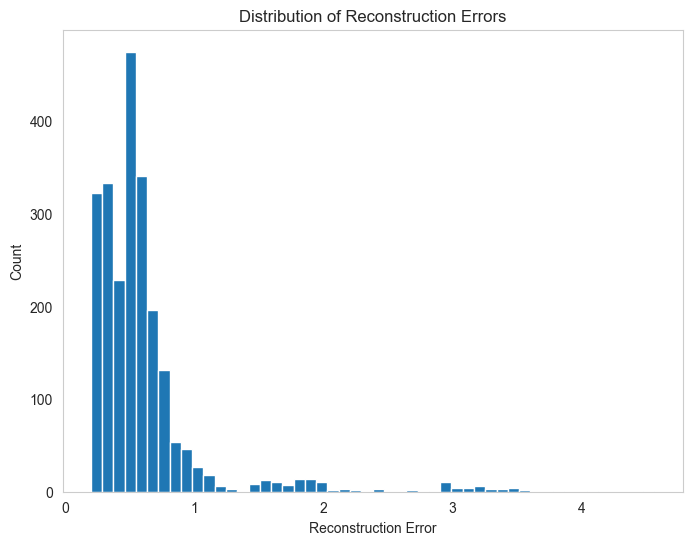

In [481]:
# Plot reconstruction error distribution
plt.figure(figsize=(8, 6))
plt.hist(valid_mse, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.show()

In [483]:
# 設定閾值範圍
thresholds = np.linspace(0.1, 10, 50)

best_threshold = 0.1  # 初始閾值
best_f1 = 0

for threshold in thresholds:
    y_pred_adjusted = (valid_mse >= threshold).astype(int)
    precision = precision_score(y_valid, y_pred_adjusted, zero_division=0)
    recall = recall_score(y_valid, y_pred_adjusted, zero_division=0)
    f1 = f1_score(y_valid, y_pred_adjusted, zero_division=0)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    # 更新最佳閾值
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}")

Threshold: 0.10, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.30, Precision: 0.0642, Recall: 0.8849, F1-score: 0.1198
Threshold: 0.50, Precision: 0.0677, Recall: 0.5755, F1-score: 0.1212
Threshold: 0.71, Precision: 0.0677, Recall: 0.2158, F1-score: 0.1031
Threshold: 0.91, Precision: 0.0893, Recall: 0.1439, F1-score: 0.1102
Threshold: 1.11, Precision: 0.1053, Recall: 0.1151, F1-score: 0.1100
Threshold: 1.31, Precision: 0.0985, Recall: 0.0935, F1-score: 0.0959
Threshold: 1.51, Precision: 0.0909, Recall: 0.0791, F1-score: 0.0846
Threshold: 1.72, Precision: 0.1134, Recall: 0.0791, F1-score: 0.0932
Threshold: 1.92, Precision: 0.1549, Recall: 0.0791, F1-score: 0.1048
Threshold: 2.12, Precision: 0.1923, Recall: 0.0719, F1-score: 0.1047
Threshold: 2.32, Precision: 0.2174, Recall: 0.0719, F1-score: 0.1081
Threshold: 2.52, Precision: 0.2093, Recall: 0.0647, F1-score: 0.0989
Threshold: 2.73, Precision: 0.2195, Recall: 0.0647, F1-score: 0.1000
Threshold: 2.93, Precision: 0.2432

In [484]:
# Use best threshold to predict on test data
test_pred = autoencoder.predict(X_test_scaled)
test_mse = np.mean(np.power(X_test_scaled - test_pred, 2), axis=1)
y_pred_test = (test_mse >= best_threshold).astype(int)

# Calculate metrics
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print("AutoEncoder Performance:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}") 
print(f"F1-score: {test_f1:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
AutoEncoder Performance:
Precision: 0.0584
Recall: 0.4928
F1-score: 0.1045


## 4.4 Plot the distributation

In [173]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
y = df['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [183]:
from sklearn.decomposition import KernelPCA
import plotly.express as px

# 使用 KernelPCA 將特徵降至 3 維
kpca = KernelPCA(n_components=3, kernel='rbf')
kpca_model = kpca.fit(X_train_scaled)
X_train_kpca = kpca_model.transform(X_train_scaled)

# 將降維後的數據轉換為 DataFrame
df_kpca = pd.DataFrame(X_train_kpca, columns=['KPCA1', 'KPCA2', 'KPCA3'])
df_kpca['target'] = y_train  

In [197]:
import plotly.express as px
import plotly.graph_objects as go

# Plotly Express 
fig = px.scatter_3d(
    df_kpca,
    x='KPCA1',
    y='KPCA2',
    z='KPCA3',
    color='target',
    title='3D Visualization of KPCA Components',
    labels={'target': 'Fraud'},
    color_discrete_sequence=px.colors.qualitative.Set1
)


fig.update_layout(
    scene = dict(
        xaxis_title='KPCA 1',
        yaxis_title='KPCA 2',
        zaxis_title='KPCA 3'
    ),
    width=600,
    height=600,
    showlegend=True
)


fig.show()

上圖顯示異常偵測方法可能沒辦法很好的分辨詐欺樣本

# 5. Export the best model

In [404]:
# Export the balanced random forest model
import pickle
import os

# Save the model
with open('../app/models/balbag_xgboost.pkl', 'wb') as f:
    pickle.dump(balbag, f)


#這個model太大，需壓縮


In [433]:
import pickle

# 使用 pickle 保存模型
with open("../app/models/xgboost_new2", "wb") as f:
    pickle.dump(xgb, f, protocol=4)

In [408]:
# export testing data
X_test_selected.to_csv('../data/processed/testing data.csv', index = True)